In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
from pathlib import Path

import multiprocessing as mp
mp.set_start_method("fork")
from concurrent.futures import ProcessPoolExecutor, as_completed
import seaborn as sns
sns.set_context("talk")

In [2]:
def load_file(f):
    print(f)
    df = pd.read_csv(f"{f}", parse_dates=[0], index_col=[0], low_memory=False)
    if isinstance(f, str):
        node_name = f.split('_')[1]
        jobid = f.split('_')[2].split('.')[0]
    else:
        node_name = f.name.split('_')[1]
        jobid = f.name.split('_')[2]
    df["node"] = node_name
    df["jobid"] = jobid
    
    return df


### Load in data

In [3]:
%%time

files = [
    # "data/condor_nid00317_62409435.csv",
    "data/condor_nid00331_62441094.csv"
]

files = Path('data').glob("*_610658*.csv")

executor = ProcessPoolExecutor(max_workers=4)

futures = [executor.submit(load_file, f) for f in files]
_all = [f.result() for f in as_completed(futures)]

total_data = pd.concat(_all)

total_data['mem_rss_GB'] = total_data['mem_rss'] / (1024**3)
total_data['mem_vms_GB'] = total_data['mem_vms'] / (1024**3)
total_data['name'] = total_data.name.astype(str)
total_data = total_data[~total_data.name.str.contains('condor')]
total_data = total_data[~total_data.name.str.contains('bash')]
total_data = total_data[~total_data.name.str.contains('srun')]
total_data = total_data[~total_data.name.str.contains('tee')]
total_data = total_data[~total_data.name.str.contains('shifter')]
total_data = total_data[~total_data.name.str.contains('sleep')]

total_data.sort_index(inplace=True)

data/condor_nid00498_61065861.csv
data/condor_nid00302_61065866.csvdata/condor_nid00301_61065896.csv

data/condor_nid00337_61065868.csv
data/condor_nid00307_61065892.csv
data/condor_nid00368_61065897.csv
data/condor_nid00318_61065898.csv
data/condor_nid00406_61065859.csv
data/condor_nid00362_61065864.csv
data/condor_nid00333_61065893.csv
data/condor_nid00441_61065858.csv
data/condor_nid00299_61065894.csv
data/condor_nid00500_61065865.csv
data/condor_nid00300_61065867.csv
data/condor_nid00341_61065863.csv
CPU times: user 39.3 s, sys: 22.2 s, total: 1min 1s
Wall time: 11min 1s


Process ForkProcess-4:
Process ForkProcess-2:
Process ForkProcess-3:
Process ForkProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/tylern/miniforge3/envs/science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/tylern/miniforge3/envs/science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/tylern/miniforge3/envs/science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/tylern/miniforge3/envs/science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/tylern/miniforge3/envs/science/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/tylern/miniforge3/envs/science/lib/python3.9/multiprocessing/process.py", line 108, in ru

In [13]:
total_data.head(2)
# total_data.current_dir.unique()

,pid,name,num_threads,cpu_num,cpu_user,cpu_system,cpu_iowait,cpu_children_system,cpu_children_user,idle,...,read_count,write_count,read_chars,write_chars,cmdline,current_dir,node,jobid,mem_rss_GB,mem_vms_GB
@timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-13 11:58:50.408044,64974,java,18,43,0.51,0.22,0.01,0.0,0.0,NaN,...,819.0,20.0,3170836.0,56.0,/usr/bin/java|-classpath|/global/cfs/cdirs/jaw...,/global/cscratch1/sd/jaws_jtm/jaws-condor/work...,nid00441,61065858.csv,0.041252,33.244686
2022-07-13 11:58:51.082726,64974,java,17,43,1.20,0.22,0.01,0.0,0.0,NaN,...,828.0,20.0,3171406.0,56.0,/usr/bin/java|-classpath|/global/cfs/cdirs/jaw...,/global/cscratch1/sd/jaws_jtm/jaws-condor/work...,nid00441,61065858.csv,0.042049,33.244686


### Sorts unique process names by the number of time points

In [5]:
name, counts = np.unique(total_data.name, return_counts=True)
_sort = np.argsort(counts)[::-1]

name = name[_sort]
counts = counts[_sort]

for n, c in zip(name, counts):
    print(n, c)

perl 6232473
samtools 3146223
bamCoverage 61048
gzip 30377
bgzip 28564
pigz 21663
sh 12745
hisat2-align-s 12725
java 9686
reformat.sh 9555
R 5371
tar 4953
featureCounts 310
python 26
data_plugin 15
cp 10
curl_plugin 5
mv 1


### Aggregate processes by name and give a table

In [6]:
total_data.groupby('name').agg(
    {
        'mem_rss_GB': ['max', 'mean'],
        'mem_vms_GB': ['max', 'mean'],
        'num_threads' : ['max', 'mean'],
    }
)

mem_rss_GB           mem_vms_GB            num_threads  \
                      max      mean        max       mean         max   
name                                                                    
R                0.789158  0.338042   2.489410   0.937994          16   
bamCoverage      1.102875  0.381829   1.269867   0.553608           4   
bgzip            0.016392  0.012588   1.224598   0.960764          18   
cp               0.006348  0.006321   0.022427   0.022421           1   
curl_plugin      0.000198  0.000061   0.002316   0.000741           1   
data_plugin      0.000412  0.000239   0.017818   0.008448           1   
featureCounts    0.673279  0.340902   1.403027   1.371330          17   
gzip             0.000648  0.000648   0.004547   0.004547           1   
hisat2-align-s   1.013332  0.600742   2.853477   2.742428          33   
java             0.312393  0.236528  35.465115  35.314986          45   
mv               0.001122  0.001122   0.018497   0.018497           1   
perl             0.008217  0.004258   0.027245   0.027245           1   
pigz             0.045807  0.019736   4.620724   4.508369          66   
python           0.144123  0.091637   0.957989   0.669791          17   
reformat.sh      0.002533  0.002533   0.011292   0.011292           1   
samtools         0.834137  0.009480   0.946682   0.033447           3   
sh               0.000748  0.000713   0.004417   0.004299           1   
tar              0.002964  0.002311   0.020790   0.019001           1   

                           
                     mean  
name                       
R                1.787749  
bamCoverage      1.092141  
bgzip           14.000385  
cp               1.000000  
curl_plugin      1.000000  
data_plugin      1.000000  
featureCounts   14.493548  
gzip             1.000000  
hisat2-align-s  32.997485  
java            37.745819  
mv               1.000000  
perl             1.000000  
pigz            65.778332  
python          12.730769  
reformat.sh      1.000000  
samtools         1.008610  
sh               1.000000  
tar              1.000000

### Plot the memory usage of the workflow over time

perl
samtools
bamCoverage
gzip
bgzip
pigz
sh
hisat2-align-s
java
reformat.sh
R
tar
featureCounts
python
data_plugin
cp
curl_plugin
mv


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


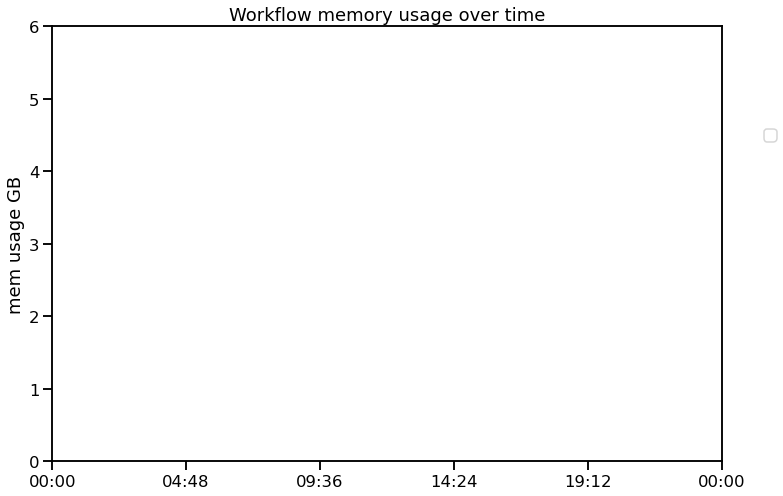

In [7]:
# remove duplicate legends
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    leg = ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(1.05, 0.75), ncol=3, fancybox=True)
    # Set legend to alpha=1.0
    # https://stackoverflow.com/a/42403471
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig, ax = plt.subplots(figsize=(12,8))
# Get a color map
cmap = cm.get_cmap('tab20')

colors = {}

bad_progs = ["alloc"]


# Give each process a unique color
for n, color in zip(name, cmap.colors):
    if n in bad_progs:
        continue
    if n in colors.keys():
        continue
    else:
        print(n)
        colors[n] = color

# Plot the memory usage over time including all processes
for n, c in zip(name, counts):
    if n in bad_progs:
        continue
    data = total_data[total_data['name'] == n]
    data = data[data.index > "2022-09-02 9:00:00.000000"]
    pids = data.pid.unique()

    for pid in pids:
        process_data = data[data.pid == pid]
        if len(process_data) < 100:
            continue
        process_data = data[data.pid == pid]
        mem = process_data.mem_vms_GB.rolling("1s").mean()
        try:
            mem.plot(c=colors[n], alpha=0.5, label=n)
        except KeyError:
            mem.plot(c='black', alpha=0.5, label="")

legend_without_duplicate_labels(ax)
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
plt.ylim(0, 6)
plt.title(f'Workflow memory usage over time')
plt.ylabel("mem usage GB")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


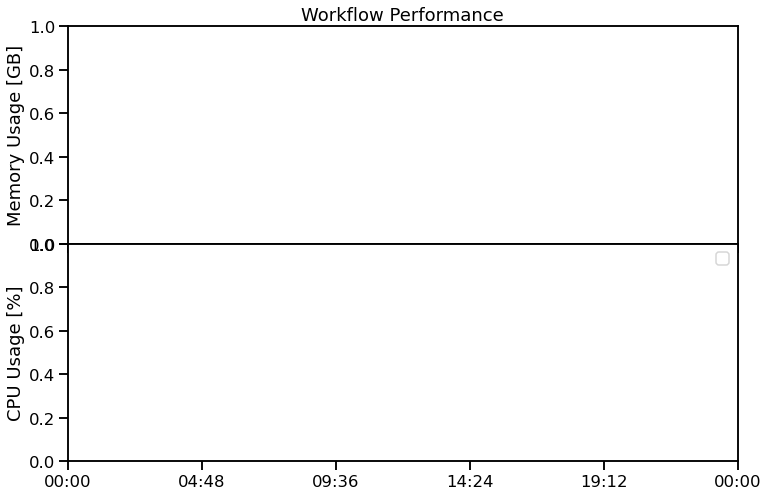

In [8]:
total_data.sort_index(inplace=True)

# remove duplicate legends
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    leg = ax.legend(*zip(*unique), 
                    #loc='center left', 
                    #bbox_to_anchor=(0.05, 0.75), 
                    ncol=3, fancybox=True)
    # Set legend to alpha=1.0
    # https://stackoverflow.com/a/42403471
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

fig, ax = plt.subplots(figsize=(12,8), nrows=2, sharex=True)

# Give each process a unique color
for n, color in zip(name, cmap.colors):
    if n in bad_progs:
        continue
    if n in colors.keys():
        continue
    else:
        print(n)
        colors[n] = color
        
bad_progs = ["pigz","mv", "sh", "cp", "data_plugin", "curl_plugin", "alloc"]
# Plot the memory usage over time including all processes
for n, c in zip(name, counts):
    if n in bad_progs:
        continue
    data = total_data[total_data['name'] == n]
    data = data[data.index > "2022-09-02 9:00:00.000000"]
    pids = data.pid.unique()

    for pid in pids:
        process_data = data[data.pid == pid]
        nid = process_data.node.iloc[0]
        jid = process_data.jobid.iloc[0]
        if len(process_data) > 10000:
            continue
        # This only works because we get the derivative over 10 seconds
        # You need to change a bit for different time intervals
        total_cpu_time = (process_data.cpu_system + process_data.cpu_user + process_data.cpu_iowait)
        cpu = (100/10)*(total_cpu_time).rolling('10s').apply(lambda x: x[-1] - x[0])
        cpu.resample('120s')
        mem = process_data.mem_vms_GB.rolling("10s").mean()
        try:
            cpu.plot(c=colors[n], alpha=0.8, label=n, ax=ax[1])
            mem.plot(c=colors[n], alpha=0.8, label=n, ax=ax[0])
        except KeyError as e:
            print(e)
            cpu.plot(c='black', alpha=0.8)

# plt.ylim(0,120)
legend_without_duplicate_labels(ax[1])

date_form = DateFormatter("%H:%M")
ax[1].xaxis.set_major_formatter(date_form)
plt.ylim(0, None)
plt.subplots_adjust(wspace=0, hspace=0)
# ax[0].set_yscale("log")
# plt.title(f'Node {nid} CPU usage jobid {jid}')
ax[0].set_title(f'Workflow Performance')
ax[1].set_ylabel("CPU Usage [%]")
ax[0].set_ylabel("Memory Usage [GB]")
plt.show()

In [9]:
colors

{'perl': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'samtools': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'bamCoverage': (1.0, 0.4980392156862745, 0.054901960784313725),
 'gzip': (1.0, 0.7333333333333333, 0.47058823529411764),
 'bgzip': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'pigz': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'sh': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'hisat2-align-s': (1.0, 0.596078431372549, 0.5882352941176471),
 'java': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'reformat.sh': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 'R': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'tar': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'featureCounts': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'python': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 'data_plugi

perl
samtools
bamCoverage
gzip
bgzip
pigz
sh
hisat2-align-s
java
reformat.sh
R
tar
featureCounts
python
data_plugin
cp
curl_plugin
mv


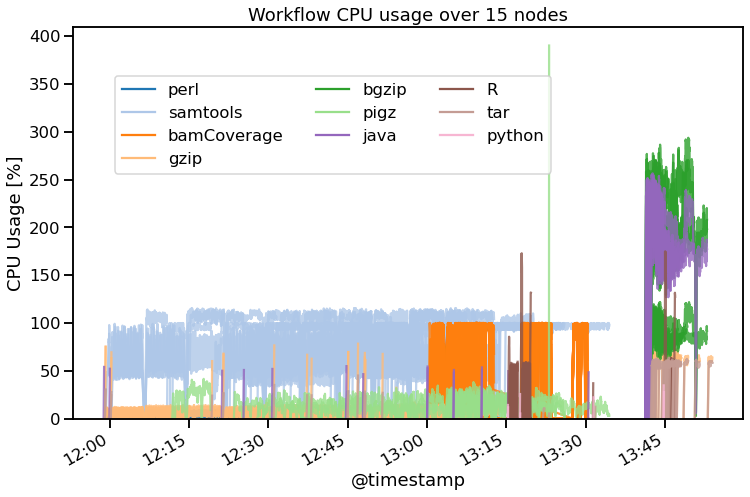

KeyboardInterrupt: 

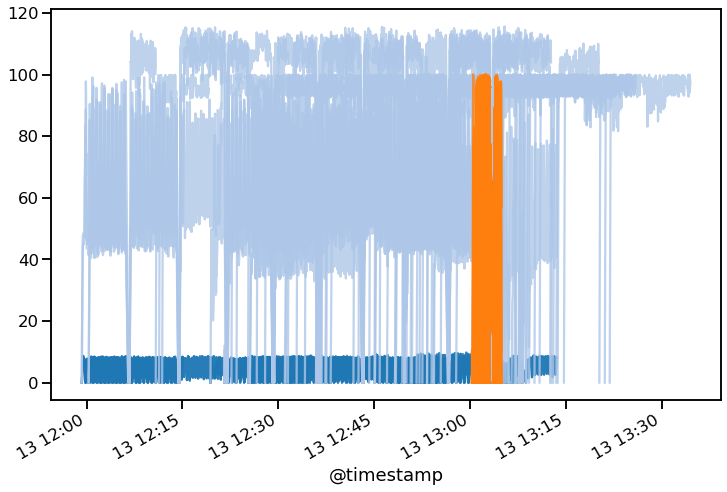

In [28]:
total_data.sort_index(inplace=True)

# remove duplicate legends
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    leg = ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(0.05, 0.75), ncol=3, fancybox=True)
    # Set legend to alpha=1.0
    # https://stackoverflow.com/a/42403471
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

nodes = total_data.node.unique()
colors = {}
# Give each process a unique color
for n, color in zip(name, cmap.colors):
    if n in colors.keys():
        continue
    else:
        print(n)
        colors[n] = color
        
for nid in nodes:
    fig, ax = plt.subplots(figsize=(12,8))

    bad_prog = ["hisat2-align-s", 'featureCounts', 'data_plugin', 'curl_plugin', 'mv', 'cp']
    # Plot the memory usage over time including all processes
    for n, c in zip(name, counts):
        if n in bad_prog:
            continue
        data = total_data[total_data['name'] == n]
        # data = data[data.node == nid]
        data = data[data.index < "2022-07-13 14:00:00.000000"]
        pids = data.pid.unique()

        for pid in pids:
            process_data = data[data.pid == pid]
            nid = process_data.iloc[0].node
            if len(process_data) > 10000:
                continue
            # This only works because we get the derivative over 10 seconds
            # You need to change a bit for different time intervals
            total_cpu_time = (process_data.cpu_system + process_data.cpu_user + process_data.cpu_iowait)
            cpu = (100/10)*(total_cpu_time).rolling('10s').apply(lambda x: x[-1] - x[0])
            cpu.resample('60s')
            try:
                if np.max(cpu) > 400:
                    continue
                if np.mean(cpu) < 2:
                    continue
                cpu.plot(c=colors[n],alpha=0.8, label=n)
            except KeyError as e:
                print(e)
                cpu.plot(c='black', alpha=0.8)

    # plt.ylim(0,120)
    legend_without_duplicate_labels(ax)

    date_form = DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_form)
    plt.ylim(0,None)
    plt.title(f'Workflow CPU usage over {len(nodes)} nodes')
    plt.ylabel("CPU Usage [%]")
    plt.show()